# <font color='red'> Spoken Digit Recognition</font>


In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>Instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. Please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>



In [1]:
import numpy as np
import pandas as pd
import librosa
import os
##if you need any imports you can do that here. 

We shared recordings.zip, please unzip those. 

In [2]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
import os

files= os.listdir('recordings')
all_files=[]
for file in files:
    all_files.append(os.path.abspath(os.path.join('recordings',file)))


In [3]:
all_files[0]

'C:\\Users\\HP\\Downloads\\spoken_digit\\spoken_digit\\recordings\\0_jackson_0.wav'

<font size=4>Grader function 1 </font>

In [4]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

## Exploring the sound dataset

In [ ]:
#It is a good programming practise to explore the dataset that you are dealing with. This dataset is unique in itself because it has sounds as input
#https://colab.research.google.com/github/Tyler-Hilbert/AudioProcessingInPythonWorkshop/blob/master/AudioProcessingInPython.ipynb
#visualize the data and write code to play 2-3 sound samples in the notebook for better understanding.
#please go through the following reference video https://www.youtube.com/watch?v=37zCgCdV468

In [13]:
!pip install thinkdsp

ERROR: Could not find a version that satisfies the requirement thinkdsp (from versions: none)
ERROR: No matching distribution found for thinkdsp


In [ ]:
# Read in audio file
# FIXME - will this work for non wav files
wave = thinkdsp.read_wave('AudioProcessingInPythonWorkshop/test.wav')

# Grab first 10 seconds of audio (you can ignore me)
clipLength = 10 # in seconds
index = 0
while (index < wave.ts.size and wave.ts[index] < clipLength):
	index += 1
# Remove extras
wave.ts = wave.ts[:index]
wave.ys = wave.ys[:index]

# Plot spectrum of audio file
spectrum = wave.make_spectrum()
spectrum.plot()
pyplot.show()

# Play audio file
wave.play()
IPython.display.Audio('sound.wav')

## Creating dataframe

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0


In [5]:
label=[]
for path in files:
    label.append(path[0])

In [6]:
df_audio= pd.DataFrame(columns=['path','label'])
df_audio['path']= all_files
df_audio['label']= label

In [7]:
df_audio.head()

,path,label
0,C:\Users\HP\Downloads\spoken_digit\spoken_digi...,0
1,C:\Users\HP\Downloads\spoken_digit\spoken_digi...,0
2,C:\Users\HP\Downloads\spoken_digit\spoken_digi...,0
3,C:\Users\HP\Downloads\spoken_digit\spoken_digi...,0
4,C:\Users\HP\Downloads\spoken_digit\spoken_digi...,0


In [8]:
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [9]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [10]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [11]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_audio['path'],df_audio['label'], test_size=0.3,stratify=df_audio['label'], random_state=42)


In [12]:
X_train.shape

(1400,)

<font size=4>Grader function 3 </font>

In [13]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [14]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        return [samples, duration]
    else:
        return samples

In [15]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
X_train_processed = []
for x in X_train:
    X_train_processed.append(load_wav(x, get_duration=True))
X_train_processed=pd.DataFrame(X_train_processed,columns=['raw_data','duration'])
X_train_processed.head()

,raw_data,duration
0,"[-1.8207456e-05, -8.338033e-05, -0.00010331021...",0.363900
1,"[9.6588104e-05, 0.00012566414, 0.00016156163, ...",0.314785
2,"[-0.00027579028, -0.00031114486, -0.000292675,...",0.349660
3,"[0.00021909502, 0.0002477661, 0.00026524728, 0...",0.566893
4,"[-4.8777634e-05, -8.546371e-05, -0.0001339433,...",0.509025


In [16]:
X_test_processed = []
for x in X_test:
    X_test_processed.append(load_wav(x, get_duration=True))
X_test_processed=pd.DataFrame(X_test_processed,columns=['raw_data','duration'])
X_test_processed.head()

,raw_data,duration
0,"[7.5200514e-05, 0.00067946606, 0.0011661825, 0...",0.316281
1,"[-0.00746698, -0.0061093145, -0.0028450494, 0....",0.374785
2,"[-0.010753613, -0.0025474587, 0.006818897, 0.0...",0.569751
3,"[-0.008190532, -0.005059408, 0.005092152, 0.01...",0.381270
4,"[0.00034301207, 0.0002433633, 4.777004e-05, -0...",0.453878


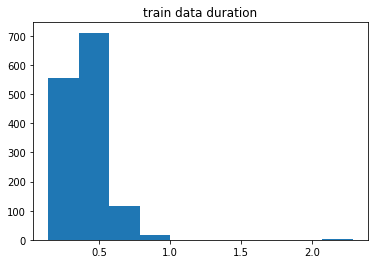

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
plt.hist(X_train_processed['duration'])
plt.title('train data duration')
plt.show()

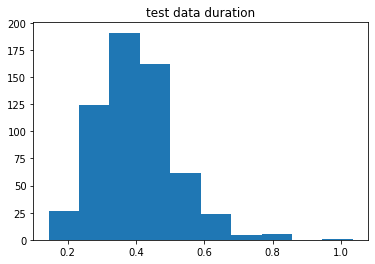

In [18]:
plt.figure(figsize=(6,4))
plt.hist(X_test_processed['duration'])
plt.title('test data duration')
plt.show()

In [19]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for p in range(0,101,10):
    print(p, "percentile value is", np.percentile(X_train_processed['duration'], p))

0 percentile value is 0.1435374149659864
10 percentile value is 0.25976870748299324
20 percentile value is 0.29777777777777775
30 percentile value is 0.3302766439909297
40 percentile value is 0.3580498866213152
50 percentile value is 0.38945578231292516
60 percentile value is 0.4164172335600907
70 percentile value is 0.44616780045351473
80 percentile value is 0.48358276643990933
90 percentile value is 0.5621632653061226
100 percentile value is 2.282766439909297


In [20]:
##print 90 to 100 percentile values with step size of 1. 
for p in range(90,101):
    print(p, "percentile value is", np.percentile(X_train_processed['duration'], p))

90 percentile value is 0.5621632653061226
91 percentile value is 0.5790390022675738
92 percentile value is 0.5933351473922903
93 percentile value is 0.6066258503401363
94 percentile value is 0.6213378684807256
95 percentile value is 0.6346916099773242
96 percentile value is 0.6484607709750566
97 percentile value is 0.6743265306122448
98 percentile value is 0.7120553287981859
99 percentile value is 0.8067614512471656
100 percentile value is 2.282766439909297


<font size=4>Grader function 4 </font>

In [21]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [22]:
max_length  = 17640

In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

In [23]:
X_train_pad_seq=[]
X_train_mask=[]
for x in X_train_processed['raw_data']:
    if len(x)<17640:
        x1=np.concatenate((x , np.zeros(17640-len(x), dtype=bool)))
        X_train_pad_seq.append(x1)
        mask=np.concatenate((np.ones(len(x), dtype=bool) , np.zeros(17640-len(x), dtype=bool)))
        X_train_mask.append(mask)
        
    else:
        X_train_pad_seq.append(x[:17640])
        X_train_mask.append(np.ones(17640, dtype=bool))
        
X_train_pad_seq= np.array(X_train_pad_seq)
X_train_mask = np.array(X_train_mask)      

In [24]:
X_test_pad_seq=[]
X_test_mask=[]
for x in X_test_processed['raw_data']:
    if len(x)<17640:
        x1=np.concatenate((x , np.zeros(17640-len(x),dtype=bool)))
        X_test_pad_seq.append(x1)
        mask=np.concatenate((np.ones(len(x),dtype=bool) , np.zeros(17640-len(x), dtype=bool)))
        X_test_mask.append(mask)
        
    else:
        X_test_pad_seq.append(x[:17640])
        X_test_mask.append(np.ones(17640,dtype=bool))
        
X_test_pad_seq= np.array(X_test_pad_seq)
X_test_mask = np.array(X_test_mask)      

<font size=4>Grader function 5 </font>

In [25]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 


Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). Also check the datatype of class labels(y_values) and make sure that you convert your class labels  to integer datatype before fitting in the model.
3. While defining your model make sure that you pass both the input layer and mask input layer as input to lstm layer as follows
<img src='https://i.imgur.com/FvcgvbY.jpg'>
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 

5. make sure that it won't overfit. 
6. You are free to include any regularization


In [26]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [ ]:
## as discussed above, please write the architecture of the model.
## you will have two input layers in your model (data input layer and mask input layer)
## make sure that you have defined the data type of masking layer as bool


In [27]:
from sklearn.metrics import f1_score
class Metrics(tf.keras.callbacks.Callback ):
    def __init__(self,validation_data):

        super().__init__()
        self.x_test=validation_data[0]
        self.y_test=validation_data[1]

    def on_epoch_end(self, epoch, logs={}):

        val_predict = (np.asarray(self.model.predict([self.x_test[0],self.x_test[1]])))
        val_label=np.argmax(val_predict,axis=1)
        val_targ = self.y_test
        val_f1 = f1_score(val_targ, val_label,average='micro')
        print ("Val_F1score = ",val_f1)

In [38]:
input_layer= Input(shape=(17640,1))
input_layer2 = Input( shape=(17640,))
lstm = LSTM(32, activation='relu')(inputs=input_layer, mask=input_layer2)
dense= Dense(64, activation='relu')(lstm)
output= Dense(10, activation='softmax')(dense)

model= Model([input_layer,input_layer2],output)
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam')
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 32)           4352        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 64)           2112        ['lstm_1[0][0]']           

In [27]:
y_train_int = y_train.apply(lambda x: int(x))
y_test_int = y_test.apply(lambda x: int(x))
y_train_int=y_train_int.values
y_test_int=y_test_int.values

In [32]:
import os
import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

log_dir = os.path.join("logs1",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

filepath="model_save/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_f1',  verbose=1, mode='auto')  
metric = Metrics(validation_data=[[X_test_pad_seq,X_test_mask],y_test_int])

callbacks= [tensorboard_callback,checkpoint, metric]

In [33]:
model.fit([X_train_pad_seq,X_train_mask], y_train_int, epochs=3,verbose=1,batch_size=12, callbacks =callbacks, validation_data=([X_test_pad_seq,X_test_mask],y_test_int))

Epoch 1/3
117/117 [==============================] - ETA: 0s - loss: 2.3032 
Epoch 1: saving model to model_save\weights-01.hdf5
Val_F1score =  0.10000000000000002
117/117 [==============================] - 5137s 44s/step - loss: 2.3032 - val_loss: 2.3026
Epoch 2/3
117/117 [==============================] - ETA: 0s - loss: 2.3030 
Epoch 2: saving model to model_save\weights-02.hdf5
Val_F1score =  0.10166666666666667
117/117 [==============================] - 6415s 55s/step - loss: 2.3030 - val_loss: 2.3026
Epoch 3/3
117/117 [==============================] - ETA: 0s - loss: 2.3029 
Epoch 3: saving model to model_save\weights-03.hdf5
Val_F1score =  0.10166666666666667
117/117 [==============================] - 5230s 45s/step - loss: 2.3029 - val_loss: 2.3026


In [34]:
val_predict = (np.asarray(model.predict([X_test_pad_seq,X_test_mask])))
val_label=np.argmax(val_predict,axis=1)
val_targ = y_test_int
val_f1 = f1_score(val_targ, val_label,average='micro')
print ("Val_F1score = ",val_f1)

Val_F1score =  0.10166666666666667


In [35]:
%load_ext tensorboard
%tensorboard --logdir logs1/fits

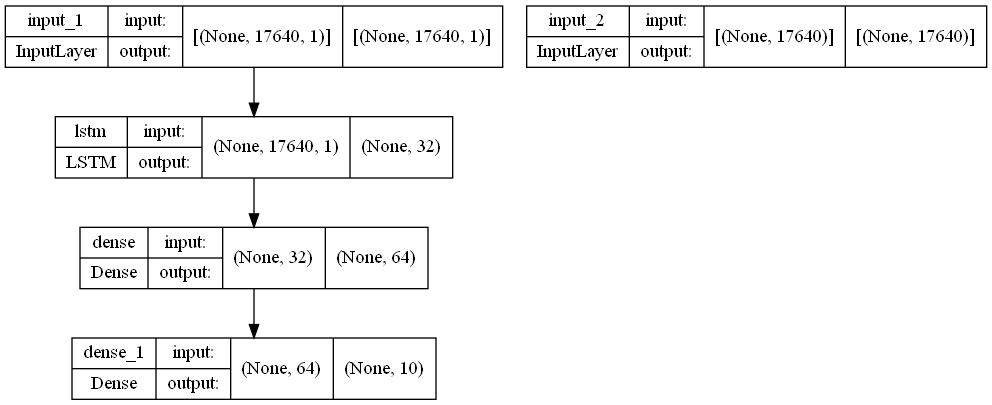

In [21]:
filepath='model1.png'
tf.keras.utils.plot_model(model,to_file=filepath,show_shapes=True)

In [39]:
#train your model
#model1.fit([X_train_pad_seq,X_train_mask],y_train_int,.........)

### 2. Converting into spectrogram and giving spectrogram data as input  

We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram


In [27]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [29]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = convert_to_spectrogram(X_train_pad_seq)
X_test_spectrogram = convert_to_spectrogram(X_test_pad_seq)

In [30]:
X_train_spectrogram.shape

(1400, 64, 35)

<font size=4>Grader function 6 </font>

In [31]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True


Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (None, time_steps, features) average the output of every time step i.e, you should get (None,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 
5. make sure that it won't overfit. 
6. You are free to include any regularization


In [ ]:
# write the architecture of the model
#print model.summary and make sure that it is following point 2 mentioned above

In [32]:
from sklearn.metrics import f1_score
class Metrics(tf.keras.callbacks.Callback ):
    def __init__(self,validation_data):

        super().__init__()
        self.x_test=validation_data[0]
        self.y_test=validation_data[1]

    def on_epoch_end(self, epoch, logs={}):

        val_predict = (np.asarray(self.model.predict(self.x_test)))
        val_label=np.argmax(val_predict,axis=1)
        val_targ = self.y_test
        val_f1 = f1_score(val_targ, val_label,average='micro')
        print ("Val_F1score = ",val_f1)

In [38]:
from tensorflow.python.keras.layers.core import TFOpLambda

In [47]:
from tensorflow.keras.layers import GlobalAveragePooling1D

def mean_layer(x):
    return tf.math.reduce_mean(x,axis=2)

input_layer= Input(shape=(64,35))
lstm = LSTM(32, activation='relu', return_sequences=True)(input_layer)
mean= TFOpLambda(mean_layer)(lstm)
#AvgPool = GlobalAveragePooling1D()(mean)
dense= Dense(32, activation='relu')(mean)
output= Dense(10, activation='softmax')(dense)

model1= Model(input_layer,output)
model1.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics='accuracy')
print(model1.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 64, 32)            8704      
                                                                 
 tf.math.reduce_mean_7 (TFOp  (None, 64)               0         
 Lambda)                                                         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 10)                330       
                                                                 
Total params: 11,114
Trainable params: 11,114
Non-trainable params: 0
_______________________________________________________

In [50]:
import os
import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

log_dir = os.path.join("logs1",'fits2', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

filepath="model_save/weights2-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_f1', verbose=1, mode='auto')  
metric = Metrics(validation_data=[X_test_spectrogram,y_test_int])

callbacks= [tensorboard_callback,checkpoint, metric]

In [51]:
model1.fit(X_train_spectrogram, y_train_int, epochs=50,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 2.4490 - accuracy: 0.1043
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.07333333333333333
117/117 [==============================] - 15s 128ms/step - loss: 2.4490 - accuracy: 0.1043 - val_loss: 2.5374 - val_accuracy: 0.0733
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 2.4156 - accuracy: 0.1164
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.08833333333333333
117/117 [==============================] - 15s 125ms/step - loss: 2.4156 - accuracy: 0.1164 - val_loss: 2.5509 - val_accuracy: 0.0883
Epoch 3/50
117/117 [==============================] - ETA: 0s - loss: 2.3964 - accuracy: 0.1093
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.125
117/117 [==============================] - 15s 126ms/step - loss: 2.3964 - accuracy: 0.1093 - val_loss: 2.5013 - val_accuracy: 0.1250
Epoch 4/50
117/117 [==============================] - ETA: 0

Epoch 27/50
117/117 [==============================] - ETA: 0s - loss: 2.1090 - accuracy: 0.2471
Epoch 27: saving model to model_save\weights2-27.hdf5
Val_F1score =  0.21166666666666667
117/117 [==============================] - 15s 128ms/step - loss: 2.1090 - accuracy: 0.2471 - val_loss: 2.1911 - val_accuracy: 0.2117
Epoch 28/50
117/117 [==============================] - ETA: 0s - loss: 2.0909 - accuracy: 0.2386
Epoch 28: saving model to model_save\weights2-28.hdf5
Val_F1score =  0.23333333333333334
117/117 [==============================] - 15s 129ms/step - loss: 2.0909 - accuracy: 0.2386 - val_loss: 2.1356 - val_accuracy: 0.2333
Epoch 29/50
117/117 [==============================] - ETA: 0s - loss: 2.0554 - accuracy: 0.2486
Epoch 29: saving model to model_save\weights2-29.hdf5
Val_F1score =  0.245
117/117 [==============================] - 15s 130ms/step - loss: 2.0554 - accuracy: 0.2486 - val_loss: 2.1434 - val_accuracy: 0.2450
Epoch 30/50
117/117 [==============================] -

In [52]:
model1.fit(X_train_spectrogram, y_train_int, epochs=50,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 1.7144 - accuracy: 0.3571
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.37666666666666665
117/117 [==============================] - 15s 131ms/step - loss: 1.7144 - accuracy: 0.3571 - val_loss: 1.7144 - val_accuracy: 0.3767
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 1.6762 - accuracy: 0.3779
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.375
117/117 [==============================] - 15s 129ms/step - loss: 1.6762 - accuracy: 0.3779 - val_loss: 1.7140 - val_accuracy: 0.3750
Epoch 3/50
117/117 [==============================] - ETA: 0s - loss: 1.6561 - accuracy: 0.3814
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.325
117/117 [==============================] - 15s 130ms/step - loss: 1.6561 - accuracy: 0.3814 - val_loss: 1.6915 - val_accuracy: 0.3250
Epoch 4/50
117/117 [==============================] - ETA: 0s - loss: 1.67

Epoch 27/50
117/117 [==============================] - ETA: 0s - loss: 1.3739 - accuracy: 0.4700
Epoch 27: saving model to model_save\weights2-27.hdf5
Val_F1score =  0.415
117/117 [==============================] - 15s 127ms/step - loss: 1.3739 - accuracy: 0.4700 - val_loss: 1.4756 - val_accuracy: 0.4150
Epoch 28/50
117/117 [==============================] - ETA: 0s - loss: 1.3396 - accuracy: 0.4843
Epoch 28: saving model to model_save\weights2-28.hdf5
Val_F1score =  0.5033333333333333
117/117 [==============================] - 15s 130ms/step - loss: 1.3396 - accuracy: 0.4843 - val_loss: 1.3713 - val_accuracy: 0.5033
Epoch 29/50
117/117 [==============================] - ETA: 0s - loss: 1.3655 - accuracy: 0.4693
Epoch 29: saving model to model_save\weights2-29.hdf5
Val_F1score =  0.4483333333333333
117/117 [==============================] - 15s 128ms/step - loss: 1.3655 - accuracy: 0.4693 - val_loss: 1.4405 - val_accuracy: 0.4483
Epoch 30/50
117/117 [==============================] - E

In [53]:
model1.fit(X_train_spectrogram, y_train_int, epochs=50,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.6093
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.585
117/117 [==============================] - 15s 132ms/step - loss: 1.0006 - accuracy: 0.6093 - val_loss: 1.0448 - val_accuracy: 0.5850
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.6007
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.5733333333333334
117/117 [==============================] - 15s 126ms/step - loss: 1.0292 - accuracy: 0.6007 - val_loss: 1.1188 - val_accuracy: 0.5733
Epoch 3/50
117/117 [==============================] - ETA: 0s - loss: 0.9854 - accuracy: 0.6293
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.555
117/117 [==============================] - 15s 127ms/step - loss: 0.9854 - accuracy: 0.6293 - val_loss: 1.1204 - val_accuracy: 0.5550
Epoch 4/50
117/117 [==============================] - ETA: 0s - loss: 0.977

In [54]:
model1.fit(X_train_spectrogram, y_train_int, epochs=50,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.4871
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.445
117/117 [==============================] - 12s 103ms/step - loss: 1.3085 - accuracy: 0.4871 - val_loss: 1.3783 - val_accuracy: 0.4450
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 1.2628 - accuracy: 0.5200
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.515
117/117 [==============================] - 13s 110ms/step - loss: 1.2628 - accuracy: 0.5200 - val_loss: 1.2908 - val_accuracy: 0.5150
Epoch 3/50
117/117 [==============================] - ETA: 0s - loss: 1.2418 - accuracy: 0.5250
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.5083333333333333
117/117 [==============================] - 13s 113ms/step - loss: 1.2418 - accuracy: 0.5250 - val_loss: 1.2808 - val_accuracy: 0.5083
Epoch 4/50
117/117 [==============================] - ETA: 0s - loss: 1.293

In [55]:
model1.fit(X_train_spectrogram, y_train_int, epochs=20,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.7379
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.6866666666666666
117/117 [==============================] - 13s 110ms/step - loss: 0.6230 - accuracy: 0.7379 - val_loss: 0.8500 - val_accuracy: 0.6867
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.7557
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.6933333333333334
117/117 [==============================] - 13s 115ms/step - loss: 0.6366 - accuracy: 0.7557 - val_loss: 0.8109 - val_accuracy: 0.6933
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.7400
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.7233333333333334
117/117 [==============================] - 13s 113ms/step - loss: 0.6413 - accuracy: 0.7400 - val_loss: 0.7425 - val_accuracy: 0.7233
Epoch 4/20
117/117 [=============================

In [56]:
model1.fit(X_train_spectrogram, y_train_int, epochs=20,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.7429
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.7283333333333334
117/117 [==============================] - 17s 145ms/step - loss: 0.6307 - accuracy: 0.7429 - val_loss: 0.7679 - val_accuracy: 0.7283
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.7614
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.7183333333333334
117/117 [==============================] - 17s 146ms/step - loss: 0.6241 - accuracy: 0.7614 - val_loss: 0.7247 - val_accuracy: 0.7183
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.7529
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.7266666666666666
117/117 [==============================] - 17s 147ms/step - loss: 0.6210 - accuracy: 0.7529 - val_loss: 0.7301 - val_accuracy: 0.7267
Epoch 4/20
117/117 [=============================

In [57]:
model1.fit(X_train_spectrogram, y_train_int, epochs=20,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.7750
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.7316666666666667
117/117 [==============================] - 15s 128ms/step - loss: 0.5753 - accuracy: 0.7750 - val_loss: 0.7146 - val_accuracy: 0.7317
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.5740 - accuracy: 0.7714
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.6933333333333334
117/117 [==============================] - 15s 128ms/step - loss: 0.5740 - accuracy: 0.7714 - val_loss: 0.8082 - val_accuracy: 0.6933
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.6071 - accuracy: 0.7671
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.7333333333333333
117/117 [==============================] - 15s 127ms/step - loss: 0.6071 - accuracy: 0.7671 - val_loss: 0.7077 - val_accuracy: 0.7333
Epoch 4/20
117/117 [=============================

In [58]:
model1.fit(X_train_spectrogram, y_train_int, epochs=20,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7886
Epoch 1: saving model to model_save\weights2-01.hdf5
Val_F1score =  0.75
117/117 [==============================] - 15s 127ms/step - loss: 0.5319 - accuracy: 0.7886 - val_loss: 0.6494 - val_accuracy: 0.7500
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.7993
Epoch 2: saving model to model_save\weights2-02.hdf5
Val_F1score =  0.7566666666666667
117/117 [==============================] - 15s 127ms/step - loss: 0.5262 - accuracy: 0.7993 - val_loss: 0.6591 - val_accuracy: 0.7567
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7936
Epoch 3: saving model to model_save\weights2-03.hdf5
Val_F1score =  0.7299999999999999
117/117 [==============================] - 15s 128ms/step - loss: 0.5160 - accuracy: 0.7936 - val_loss: 0.7539 - val_accuracy: 0.7300
Epoch 4/20
117/117 [==============================] - ETA: 0s -

In [60]:
model1.load_weights('model_save/weights2-19.hdf5')
val_predict = (np.asarray(model1.predict(X_test_spectrogram)))
val_label=np.argmax(val_predict,axis=1)
val_targ = y_test_int
val_f1 = f1_score(val_targ, val_label,average='micro')
print ("Val_F1score = ",val_f1)

Val_F1score =  0.8016666666666666


In [61]:
%load_ext tensorboard
%tensorboard --logdir logs1/fits

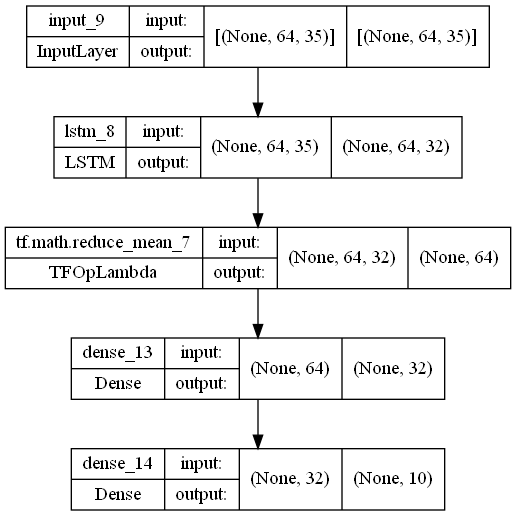

In [62]:
filepath='model2.png'
tf.keras.utils.plot_model(model1,to_file=filepath,show_shapes=True)

In [ ]:
#compile and fit your model.
#model2.fit([X_train_spectrogram],y_train_int,......)

### 3. Data augmentation with raw features 

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.


In [40]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [41]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [42]:
len(aug_temp)

9

## Follow the steps 

1. Split data 'df_audio' into train and test (80-20 split)

2. We have 2000 data points(1600 train points, 400 test points) 



In [27]:
X_train, X_test, y_train, y_test=train_test_split(df_audio['path'],df_audio['label'],random_state=45,test_size=0.2,stratify=df_audio['label'])

3. Do augmentation only on X_train,pass each point of X_train to generate_augmented_data function.After augmentation we will get 14400 train points. Make sure that you are augmenting the corresponding class labels (y_train) also.
4. Preprocess your X_test using load_wav function.
5. Convert the augmented_train_data and test_data to numpy arrays.
6. Perform padding and masking on augmented_train_data and test_data.
7. After padding define the model similar to model 1 and fit the data

In [44]:
X_train_augmented=[]
y_train_aug=[]
for x,y in zip(X_train,y_train):
    temp_aug= generate_augmented_data(x)
    X_train_augmented.extend(temp_aug)
    y_train_aug.extend([y]*9)

In [45]:
X_train_augmented= np.array(X_train_augmented)

C:\Users\HP\AppData\Local\Temp\ipykernel_25880\1686762254.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_augmented= np.array(X_train_augmented)


In [48]:
import pickle

# with open('train_augmented','wb') as f: 
#     pickle.dump(X_train_augmented, f)
    
# with open('y_train_augmented','wb') as f: 
#     pickle.dump(y_train_aug, f)

with open('train_augmented','rb') as f: 
    X_train_augmented1 = pickle.load(f)
    
with open('y_train_augmented','rb') as f: 
    y_train_augmented1 = pickle.load(f)

In [49]:
len(X_train_augmented1)

14400

In [50]:
len(y_train_augmented1)

14400

In [51]:
X_train_augmented1[0]

array([-2.2495104e-05, -6.2195526e-05, -1.0654096e-04, ...,
       -1.5071427e-04, -3.4051077e-04,  0.0000000e+00], dtype=float32)

In [52]:
y_train_augmented1[0]

'8'

In [53]:
X_test_processed = []
for x in X_test:
    X_test_processed.append(load_wav(x, get_duration=True))
X_test_processed=pd.DataFrame(X_test_processed,columns=['raw_data','duration'])
X_test_processed.head()

,raw_data,duration
0,"[7.5200514e-05, 0.00067946606, 0.0011661825, 0...",0.316281
1,"[-0.00746698, -0.0061093145, -0.0028450494, 0....",0.374785
2,"[-0.010753613, -0.0025474587, 0.006818897, 0.0...",0.569751
3,"[-0.008190532, -0.005059408, 0.005092152, 0.01...",0.381270
4,"[0.00034301207, 0.0002433633, 4.777004e-05, -0...",0.453878


In [54]:
X_train_pad_seq=[]
X_train_mask=[]
for x in X_train_augmented1:
    if len(x)<17640:
        x1=np.concatenate((x , np.zeros(17640-len(x), dtype=bool)))
        X_train_pad_seq.append(x1)
        mask=np.concatenate((np.ones(len(x), dtype=bool) , np.zeros(17640-len(x), dtype=bool)))
        X_train_mask.append(mask)
        
    else:
        X_train_pad_seq.append(x[:17640])
        X_train_mask.append(np.ones(17640, dtype=bool))
        
X_train_pad_seq= np.array(X_train_pad_seq)
X_train_mask = np.array(X_train_mask)      

In [55]:
X_test_pad_seq=[]
X_test_mask=[]
for x in X_test_processed['raw_data']:
    if len(x)<17640:
        x1=np.concatenate((x , np.zeros(17640-len(x),dtype=bool)))
        X_test_pad_seq.append(x1)
        mask=np.concatenate((np.ones(len(x),dtype=bool) , np.zeros(17640-len(x), dtype=bool)))
        X_test_mask.append(mask)
        
    else:
        X_test_pad_seq.append(x[:17640])
        X_test_mask.append(np.ones(17640,dtype=bool))
        
X_test_pad_seq= np.array(X_test_pad_seq)
X_test_mask = np.array(X_test_mask)      

In [57]:
len(X_train_pad_seq)

14400

In [36]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [27]:
from sklearn.metrics import f1_score
class Metrics(tf.keras.callbacks.Callback ):
    def __init__(self,validation_data):

        super().__init__()
        self.x_test=validation_data[0]
        self.y_test=validation_data[1]

    def on_epoch_end(self, epoch, logs={}):

        val_predict = (np.asarray(self.model.predict([self.x_test[0],self.x_test[1]])))
        val_label=np.argmax(val_predict,axis=1)
        val_targ = self.y_test
        val_f1 = f1_score(val_targ, val_label,average='micro')
        print ("Val_F1score = ",val_f1)

In [28]:
input_layer= Input(shape=(17640,1))
input_layer2 = Input( shape=(17640,))
lstm = LSTM(32, activation='relu')(inputs=input_layer, mask=input_layer2)
dense= Dense(64, activation='relu')(lstm)
output= Dense(10, activation='softmax')(dense)

model= Model([input_layer,input_layer2],output)
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 32)           4352        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           2112        ['lstm[0][0]']               

In [32]:
import os
import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

log_dir = os.path.join("logs1",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

filepath="model_save/weights3-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_f1', verbose=1, mode='auto')  
metric = Metrics(validation_data=[[X_test_pad_seq,X_test_mask],y_test_int])

callbacks= [tensorboard_callback,checkpoint, metric]

In [58]:
y_train_aug=np.array(y_train_augmented1,dtype=int)
y_train_aug

array([8, 8, 8, ..., 2, 2, 2])

In [59]:
y_test_int = y_test.apply(lambda x: int(x))
y_test_int=y_test_int.values

In [33]:
len(X_train_pad_seq[0])

17640

In [34]:
model.fit([X_train_pad_seq,X_train_mask], y_train_aug, epochs=1,verbose=1,batch_size=12, callbacks =callbacks, validation_data=([X_test_pad_seq,X_test_mask],y_test_int))

1200/1200 [==============================] - ETA: 0s - loss: 2.3030 
Epoch 1: saving model to model_save\weights3-01.hdf5
Val_F1score =  0.10000000000000002
1200/1200 [==============================] - 23553s 20s/step - loss: 2.3030 - val_loss: 2.3026


In [36]:
val_predict = (np.asarray(model.predict([X_test_pad_seq,X_test_mask])))
val_label=np.argmax(val_predict,axis=1)
val_targ = y_test_int
val_f1 = f1_score(val_targ, val_label,average='micro')
print ("Val_F1score = ",val_f1)

Val_F1score =  0.10000000000000002


In [37]:
%load_ext tensorboard
%tensorboard --logdir logs1/fits

<font color='red'> Note </font> - While fitting your model on the augmented data for model 3 you might face Resource exhaust error. One simple hack to avoid that is save the augmented_train_data,augment_y_train,test_data and y_test to Drive or into your local system. Then restart the runtime so that now you can train your model with full RAM capacity. Upload these files again in the new runtime session perform padding and masking and then fit your model.

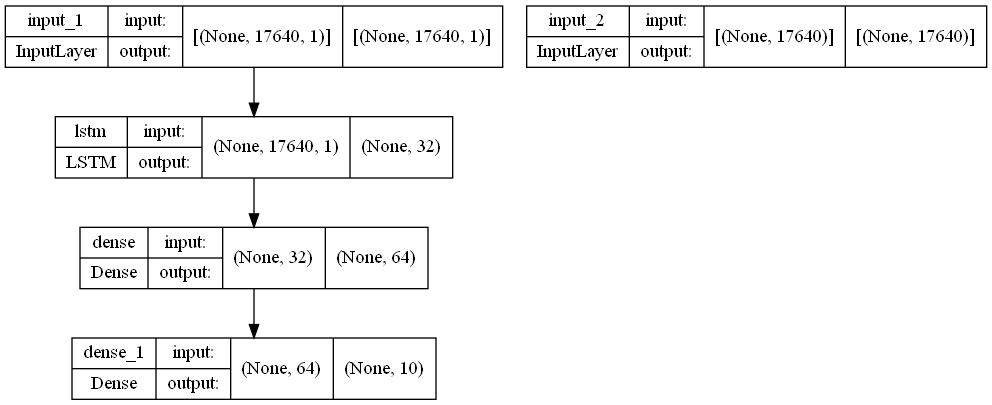

In [38]:
filepath='model3.png'
tf.keras.utils.plot_model(model,to_file=filepath,show_shapes=True)

### 4. Data augmentation with spectogram data

1. use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data

In [60]:
X_train_spectrogram = convert_to_spectrogram(X_train_pad_seq)
X_test_spectrogram = convert_to_spectrogram(X_test_pad_seq)

In [62]:
X_train_spectrogram.shape

(14400, 64, 35)

In [71]:
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers.core import TFOpLambda

def mean_layer(x):
    return tf.math.reduce_mean(x,axis=2)

input_layer= Input(shape=(64,35))
lstm = LSTM(32, activation='relu', return_sequences=True)(input_layer)
mean= TFOpLambda(mean_layer)(lstm)
#AvgPool = GlobalAveragePooling1D()(mean)
dense= Dense(32, activation='relu')(mean)
output= Dense(10, activation='softmax')(dense)

model1= Model(input_layer,output)
model1.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics='accuracy')
print(model1.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 64, 32)            8704      
                                                                 
 tf.math.reduce_mean_2 (TFOp  (None, 64)               0         
 Lambda)                                                         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 11,114
Trainable params: 11,114
Non-trainable params: 0
_______________________________________________________

In [72]:
from sklearn.metrics import f1_score
class Metrics(tf.keras.callbacks.Callback ):
    def __init__(self,validation_data):

        super().__init__()
        self.x_test=validation_data[0]
        self.y_test=validation_data[1]

    def on_epoch_end(self, epoch, logs={}):

        val_predict = (np.asarray(self.model.predict(self.x_test)))
        val_label=np.argmax(val_predict,axis=1)
        val_targ = self.y_test
        val_f1 = f1_score(val_targ, val_label,average='micro')
        print ("Val_F1score = ",val_f1)

In [73]:
import os
import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

log_dir = os.path.join("logs1",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

filepath="model_save4/weights4-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_f1',  verbose=1, mode='auto')  
metric = Metrics(validation_data=[X_test_spectrogram,y_test_int])

callbacks= [tensorboard_callback,checkpoint, metric]

In [66]:
model1.fit(X_train_spectrogram, y_train_aug, epochs=100,verbose=1,batch_size=12, callbacks =callbacks, validation_data=(X_test_spectrogram,y_test_int))

Epoch 1/100
1200/1200 [==============================] - ETA: 0s - loss: 2.3413 - accuracy: 0.1475
Epoch 1: saving model to model_save4\weights4-01.hdf5
Val_F1score =  0.22
1200/1200 [==============================] - 81s 67ms/step - loss: 2.3413 - accuracy: 0.1475 - val_loss: 2.1427 - val_accuracy: 0.2200
Epoch 2/100
1200/1200 [==============================] - ETA: 0s - loss: 1.9153 - accuracy: 0.2999
Epoch 2: saving model to model_save4\weights4-02.hdf5
Val_F1score =  0.37333333333333335
1200/1200 [==============================] - 80s 67ms/step - loss: 1.9153 - accuracy: 0.2999 - val_loss: 1.7522 - val_accuracy: 0.3733
Epoch 3/100
1200/1200 [==============================] - ETA: 0s - loss: 1.5387 - accuracy: 0.4473
Epoch 3: saving model to model_save4\weights4-03.hdf5
Val_F1score =  0.51
1200/1200 [==============================] - 84s 70ms/step - loss: 1.5387 - accuracy: 0.4473 - val_loss: 1.3634 - val_accuracy: 0.5100
Epoch 4/100
1200/1200 [==============================] - ETA:

KeyboardInterrupt: 

In [76]:
model1.load_weights('weights4-10.hdf5')

In [78]:
val_predict = (np.asarray(model1.predict(X_test_spectrogram)))
val_label=np.argmax(val_predict,axis=1)
val_targ = y_test_int
val_f1 = f1_score(val_targ, val_label,average='micro')
print ("Val_F1score = ",val_f1)

Val_F1score =  0.8633333333333333


In [79]:
%load_ext tensorboard
%tensorboard --logdir logs1/fits

Reusing TensorBoard on port 6006 (pid 19088), started 10:20:12 ago. (Use '!kill 19088' to kill it.)

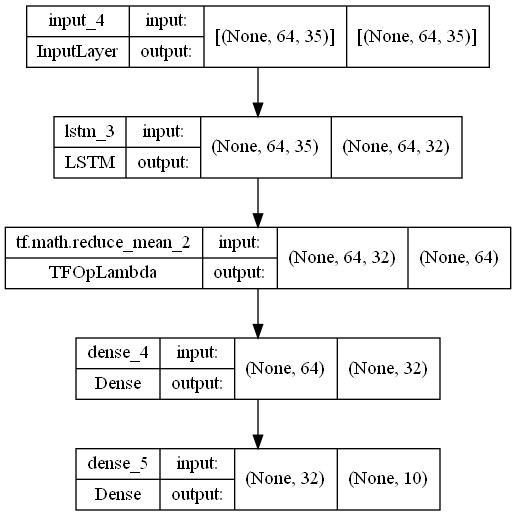

In [80]:
filepath='model4.png'
tf.keras.utils.plot_model(model1,to_file=filepath,show_shapes=True)